In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from dataloader import get_evaluation_datasets_by_client  # Assuming this function gets local client datasets
from model import Net
from collections import OrderedDict
from config import NUM_CLASSES, NUM_CLIENTS, GLOBAL_MODEL_PATH, BATCH_SIZE
from torch.utils.data import DataLoader
from utils import to_tensor
import pandas as pd

/home/sharedrive/PythonCodes/.venv311_new/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the global model from the saved path
def load_model(model_path=GLOBAL_MODEL_PATH, num_classes=NUM_CLASSES):
    model = Net(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

In [3]:
# Run inference on a client's dataset
def run_inference(model, dataloader, device):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            features, labels = batch[0].to(device), batch[1].to(device)
            outputs = model(features)
            _, preds = torch.max(outputs.data, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels)

In [4]:
def plot_confusion_matrix(y_true, y_pred, classes, title, ax):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues, ax=ax)  # Pass ax here directly
    ax.set_title(title)  # Optional: Set a title for each subplot


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = load_model()
model.to(device)    
num_clients = NUM_CLIENTS  # Define or import this variable

In [9]:
classes = np.arange(NUM_CLASSES)  # Define or import this variable

clients = [
    {
        'client_id': 1,
        'plot_name': 'Client 1',
        'plot_position': [0, 0]
    },
    {
        'client_id': 2,
        'plot_name': 'Client 2',
        'plot_position': [0, 1]
    },
    {
        'client_id': 3,
        'plot_name': 'Client 3',
        'plot_position': [1, 0]
    },
    {
        'client_id': 4,
        'plot_name': 'Client 4',
        'plot_position': [1, 1]
    }   
]

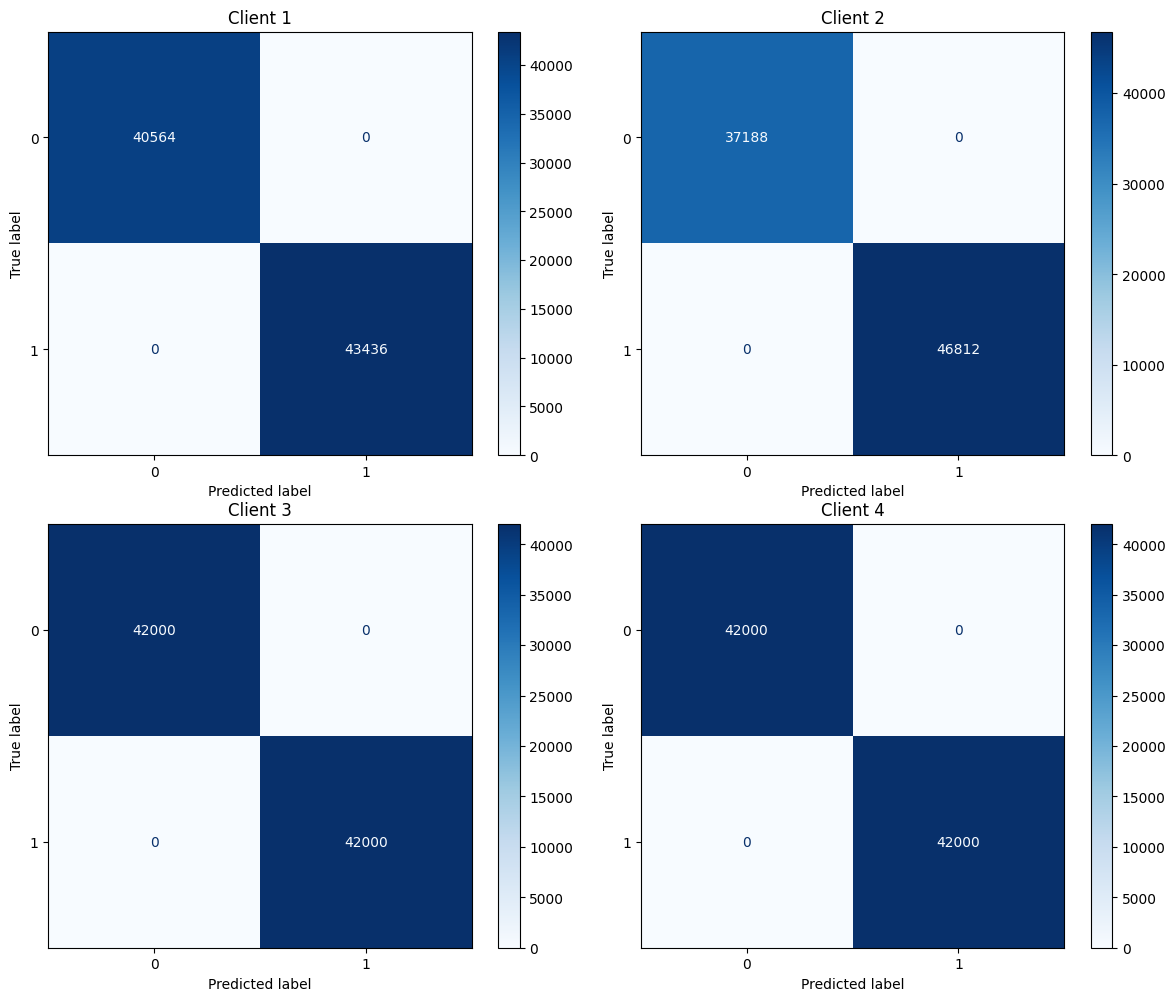

In [10]:

# Create a 2x2 grid for subplots
fig, ax = plt.subplots(2, 2, figsize=(12, 10))  # Adjust the figsize as needed

client_metrics = {
    'Client': [],
    'Description': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'Sample Number': []
}

for client in clients:
    testset = get_evaluation_datasets_by_client(client.get("client_id"))  
    testloader = DataLoader(to_tensor(testset), batch_size=BATCH_SIZE)
    preds, labels = run_inference(model, testloader, device)
    title = f"{client['plot_name']}"    
    plot_confusion_matrix(labels, preds, classes, title, ax = ax[client['plot_position'][0], client['plot_position'][1]])

    client_metrics['Client'].append(client.get("client_id"))
    client_metrics['Description'].append(client.get("plot_name"))
    client_metrics['Accuracy'].append(accuracy_score(labels, preds))
    client_metrics['Precision'].append(precision_score(labels, preds))
    client_metrics['Recall'].append(recall_score(labels, preds))
    client_metrics['F1 Score'].append(f1_score(labels, preds))
    client_metrics['Sample Number'].append(len(labels))    

plt.tight_layout()
plt.show()



In [8]:
##Showing performances
df = pd.DataFrame(client_metrics)
print(df.to_string(index=False))

 Client         Description  Accuracy  Precision  Recall  F1 Score  Sample Number
      1 ContainerTB Slice 1       1.0        1.0     1.0       1.0          84000
      2 ContainerTB Slice 2       1.0        1.0     1.0       1.0          84000
      3       VM TB Slice 1       1.0        1.0     1.0       1.0          84000
      4       VM TB Slice 1       1.0        1.0     1.0       1.0          84000
